# Gina Mazza, Ian Derickson, Adam Viray

# Softmax regression for handwritten digits

Today, we'll implement a softmax classifier recognizing handwritten digits.  We'll begin by using a relatively small collection (around 1800) of low resolution (8 by 8pix) digits.  This can be easily acquired using scikit-learn.

In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
digits = load_digits()

y = digits['target']

data = digits['data']
X = data-np.mean(data)
X /= np.std(X)

The digits appear as an $m\times n$ array, where $m$ is the number of data instances and $n$ is the number of features.  It's important to recognize that for this problem, the number of features is $8\times8 = 64$: the instances are flattened.  If you want to plot a digit from the dataset using, for example, matplotlib's imshow, you'll need to reshape this.  

You'll also want to be careful to normalize the data, preferably by subtracting the mean and dividing by the standard deviation.  

## The labels appear as integers.  Write and apply a function that converts from this integer representation to a one-hot encoding.

In [2]:
def one_hot_encoder(y):
    classes = np.unique(y)
    ident = np.identity(len(classes))
    one_hot_label = np.array([ident[i,:] for i in classes[y]])
    return one_hot_label
one_hot_label = one_hot_encoder(y)

Another important step is to split the dataset into training and testing sets.  I like using the function sklearn.model_selection.train_test_split

In [3]:
 X_train, X_test, y_train, y_test = train_test_split(X, one_hot_label, test_size=0.3, random_state=42)
m,n = X_train.shape

With data in hand, we now need to implement the model.  Recall that our predictions will be computed as
$$
Y_{pred} = \mathrm{Softmax}(\Phi W)
$$
Implement the softmax method, generate the matrix $\Phi$ (I suggest a linear model, which is to say that all you need to do will be to prepend a column of ones to the $m\times n$ matrix of pixel values, and instantiate the parameter matrix $W$ (I suggest instantiating to an array of very small random numbers).  Your implementation of Softmax should be vectorized, in that it should take a $m \times N$ array of logits and output and $m \times N$ array without using a loop.  Make a prediction using this untrained model: a sensible result at this stage is that all classes are approximately equally likely.

In [4]:
Phi = np.append(np.ones((y_train.shape[0],1)),X_train,axis=1)
w = np.random.randn(65,10)

def softmax(Phi, w):
    logits = Phi@w
    return np.exp(logits)/np.sum(np.exp(logits),axis=1).reshape(Phi.shape[0],1)

Now generate functions (or one function with multiple outputs) to compute the categorical cross entropy and its gradient.  These are given by 
$$
\mathcal{L}(W,\Phi,Y_{obs}) = -\frac{1}{mN} \sum_{i=1}^m \left(Y_{obs,i} \ln \mathrm{Softmax}(\Phi W)\right).
$$
and 
$$
\frac{ \partial \mathcal{L}}{\partial W} = -\frac{1}{mN} \sum_{i=1}^m \left[(Y_{obs,i} - \mathrm{Softmax}(\Phi W)_i) \Phi_i^T\right]^T. 
$$
As you implement these functions, consider how to do so in as efficient a manner as possible.  Note that it is possible to vectorize the sums.    

In [5]:
def cross_entropy(w, Phi, y):
    m = Phi.shape[0] # 1257
    N = w.shape[1]   # 10
    S = softmax(Phi,w)
    
    cross_entropy = -1/m/N * np.sum(np.diag(y@np.log(S).T))
    grad_cross_entropy = -1/m/N * ((y-S).T@Phi).T
    
    return cross_entropy, grad_cross_entropy

Implement gradient descent and train this model.  Record the value of $\mathcal{L}$ as a function of gradient descent iteration, and produce a plot convincing yourself that the model is converging to a minimum.

In [6]:
eta = 1
w_pos = np.random.randn(65,10)*10e-3
L_arr = []
repeat = True
n_iter = 0

while repeat:
    L, grad_L = cross_entropy(w_pos,Phi,y_train)
    w_vec = eta*grad_L
    w_pos -= w_vec
    L_arr.append(L)
    n_iter += 1
    
    if np.sum(np.abs(grad_L))<1e-3 or n_iter>10000:
        repeat = False
        
w_opt = w_pos

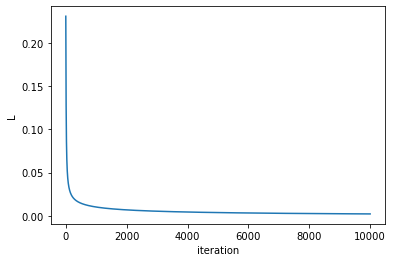

In [7]:
plt.plot(L_arr)
plt.xlabel("iteration")
plt.ylabel("L")
plt.show()

One very interesting result of working with image data is that we can interpret the learned parameters as images (the weight matrix is $N\times (1+n)$.  If you get rid of the first entry, which corresponds to a constant offset, the remaining $N \times n$ weights are each associated with a given input pixel for a given class).  Plot your weights as images (there should be ten of them).  Evaluate the pattern that you find.    

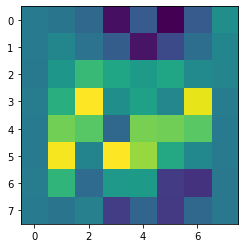

In [8]:
plt.imshow(w_opt[1:,4].reshape(8,8))

Finally, once this task is complete, scale your method up to the larger (in both number of instances and resolution) dataset MNIST (you can get it using the command sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)).  This will take substantial time to train!  Only do this once you are satisfied with your implementation on the digits dataset.  

In [9]:
import sklearn
from tqdm.notebook import tqdm
MNIST = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [10]:
X_2 = MNIST[0]
y_2 = np.array([int(x) for x in MNIST[1]])

X_2 -= np.mean(X_2)
X_2 /= np.std(X_2)

In [11]:
one_hot_label_2 = one_hot_encoder(y_2)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, one_hot_label_2, test_size=0.3, random_state=42)
m,n = X_train_2.shape

Phi_2 = np.append(np.ones((y_train_2.shape[0],1)),X_train_2,axis=1)
w_2 = np.random.randn(785,10)

In [12]:
eta = .01
w_pos = np.random.randn(785,10)*10e-3
L_arr = []
repeat = True
n_iter = 0

with tqdm(total=2000) as pbar:
    while repeat:
        L, grad_L = cross_entropy(w_pos,Phi_2,y_train_2)
        w_vec = eta*grad_L
        w_pos -= w_vec
        L_arr.append(L)
        n_iter += 1
        pbar.update(1)

        if np.sum(np.abs(grad_L))<1e-3 or n_iter>=2000:
            repeat = False

w_opt = w_pos

  0%|          | 0/2000 [00:00<?, ?it/s]

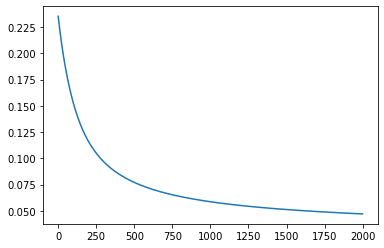

In [13]:
plt.plot(L_arr)
plt.show()

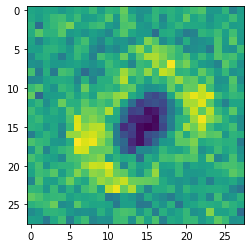

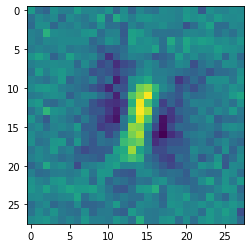

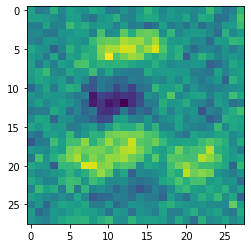

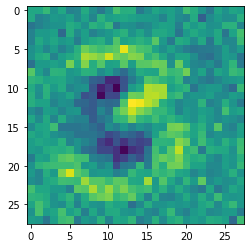

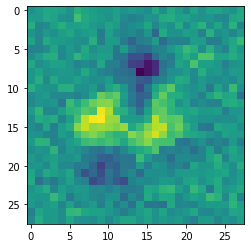

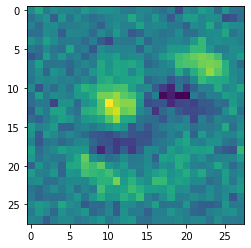

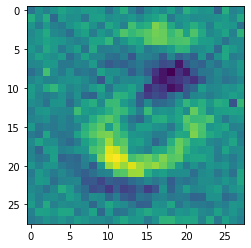

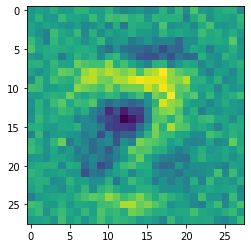

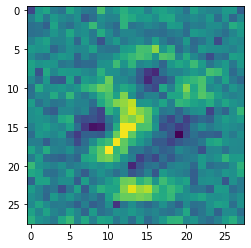

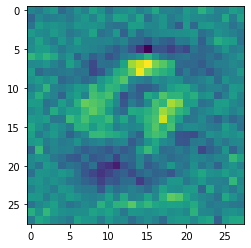

In [14]:
for i in range(10):
    plt.imshow(w_opt[1:,i].reshape(28,28))
    plt.show()

In [98]:
Phi_2 = np.append(np.ones((y_test_2.shape[0],1)),X_test_2,axis=1)
Y_pred = softmax(Phi_2,w_opt)
accuracy = [np.argmax(Y_pred[i]) == np.argmax(y_test_2[i]) for i in range(Y_pred.shape[0])]
np.mean(accuracy)

0.8770476190476191